In [ ]:
# Each agent has a budget of 1025
# Evaluation has cost c=1, acting has cost A=25
# X axis is correlation
# Dotted line for fixed-K agents
# Solid line for dynamic

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
%load_ext autoreload

In [2]:
%autoreload

from dmaker.decision_maker import FixedDecisionMaker, DynamicDecisionMaker
from dmaker.environment import DecisionEnvironment

In [34]:
k_values = [1, 2, 4, 9, 20]
sigmas = [0.1, 1, 2, 3, 4, 5]
data = pd.DataFrame(index=sigmas)

for sigma in sigmas:
    env = DecisionEnvironment(N=1000, num_trials=100, sigma=sigma, mu=0, tau=1)
    dms = [FixedDecisionMaker(env, i) for i in k_values] + [DynamicDecisionMaker(env)]
    for dm in dms:
        dm.decide()
        data.loc[sigma, dm.name] = dm.data.utility.mean()

<AxesSubplot:>

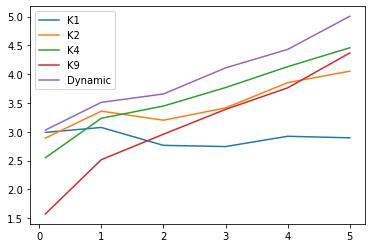

In [35]:
data.drop(columns="K20").plot()

In [213]:
# TODO: Need to change from open ended/one-off costs to fixed budget/timeline situation, in separate git branch
# Need to figure out relation between sigma and correlation rho, use that as the X axis
# -> This will get graph similar to the one in Habits of thought, but without dotted lines and instead new line of optimal agent
# Also do one with cost of evaluation on the x axis

# Follow this up with analysis of dynamic agent's probability of stopping as a function of value of action last evaluated

# Adapted from Matlab code in https://github.com/adammmorris/consideration-sets/blob/master/simulations/sims.m
import numpy as np
import matplotlib.pyplot as plt

# vals has the structure [[vhat_1, v_1], [vhat_2, v_2], ...]
# vals must be sorted by vhats before being passed to this decision function
def fixed_k_decide(k, action_cost):
    def decide(vals):
        options = vals[:k,1]
        utility = max(options)
        budget = 1000 + action_cost
        budget -= k * action_cost # for consideration time
        actions_taken = (budget // action_cost)
        return actions_taken * utility
    return decide

num_actions_all = [20, 100, 1000]
action_costs_all = [2, 5, 10, 25, 50, 100]

results_cols = ["num_actions", "action_cost", "r", "agent", "utility"]
results = pd.DataFrame(columns=results_cols)

for num_actions in num_actions_all:
    for action_cost in action_costs_all:
        k_agents = [1, 2, 3, 4, 5, 7, 9, 12, 15, 20]
        if num_actions > 20:
            k_agents += [40, 80, num_actions]
        agents = {k: fixed_k_decide(k, action_cost) for k in k_agents}
        # agents["Dynamic"] = 
        
        r_all = [0, .25, .5, .75, 1]
        
        n_envs = len(r_all)
        variance = 1
        mu = [0, 0]
        n_sizes = len(n_to_eval)
        
        num_trials = 100 #10000
        
        for cur_r in r_all:            
            sigma = [[variance, cur_r * variance], [cur_r * variance, variance]]
            
            temp_results = {agent: [] for agent in agents.keys()}
            
            for trial in range(num_trials):
                vals = np.random.multivariate_normal(mu, sigma, num_actions)
                indices = np.argsort(-vals[:,0])
                vals = np.take_along_axis(vals, np.stack([indices, indices], axis=1), axis=0)

                # evaluate for all agents
                for agent_name, agent_func in agents.items():
                    temp_results[agent_name].append(agent_func(vals))
            
            results = results.append(pd.DataFrame([[num_actions, action_cost, cur_r, agent, np.mean(temp_results[agent])] for agent in temp_results.keys()],
                                     columns=results_cols))
        #break
    #break
print(results)

   num_actions action_cost  r agent      utility
0           20           2  0     1   124.118540
1           20           2  0     2   367.899546
2           20           2  0     3   473.996900
3           20           2  0     4   530.294873
4           20           2  0     5   608.631773
..         ...         ... ..   ...          ...
8         1000         100  1    15   -12.861628
9         1000         100  1    20   -28.938663
10        1000         100  1    40   -93.246801
11        1000         100  1    80  -221.863079
12        1000         100  1  1000 -3180.037472

[1080 rows x 5 columns]


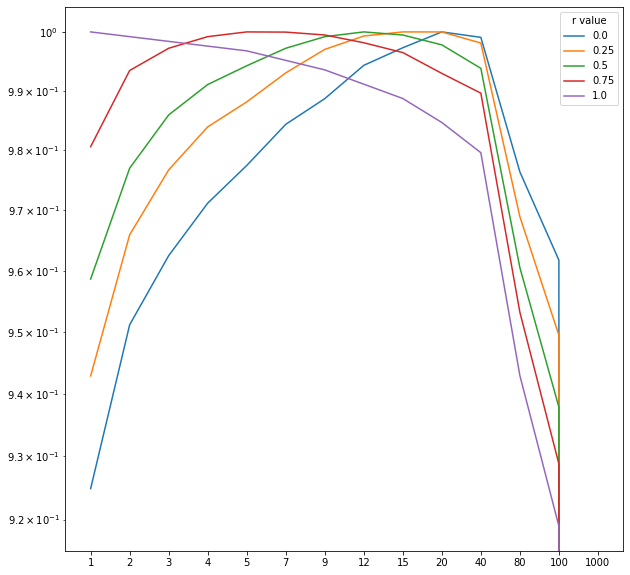

In [219]:
to_plot = results.groupby(["agent", "r"]).agg({"utility": "mean"}).reset_index()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')

for r in to_plot["r"].unique():
    subset = to_plot[to_plot["r"]==r].copy()
    subset["utility"] += min(subset["utility"]) * ((min(subset["utility"]) <= 0)  * (-1))
    subset["utility"] /= max(subset["utility"])
    plt.plot(subset["agent"].apply(lambda x: str(x)), subset["utility"], label=r)
plt.legend(title="r value")

In [208]:
#plt.plot(to_plot["agent"], to_plot["utility"], color=to_plot["r"])
to_plot.sort_values(["r", "agent"]).tail(50)

,agent,r,utility
31,9,0.25,137.807586
36,12,0.25,159.212105
41,15,0.25,174.289216
46,20,0.25,191.904724
51,40,0.25,181.900329
56,80,0.25,139.728277
61,100,0.25,116.341686
66,1000,0.25,-2765.844150
2,1,0.50,-184.989188
7,2,0.50,-98.684378


In [ ]:
"""
                    temp = mvnrnd(mu, sigma, nWords);
                    s1re = temp(:, 1);
                    s2re = temp(:, 2);
                    
                    % run cs
                    [~, options] = sort(s1re, 'descend');
                    toEval = options(1:cur_nToEval);
                    [~, choice_ind] = max(s2re(toEval));
                    choice = toEval(choice_ind);
                    csearnings(env, curSize, agent) = s2re(choice);
                end
            end
        end
        
        %% Do optimality computation, save data to be graphed
        
        cs_mean = mean(csearnings, 3);
        output = cs_mean';
        
        % get # of decisions possible for each cs size
        budget = 1000 + actioncost;
        
        nDecisions = [budget / actioncost, budget ./ (actioncost + nToEval(2:end))];
        
        % Compute the average decision value
        decisionVals = bsxfun(@times, nDecisions', output);
        decisionVals_nonzero = decisionVals(:, 2:end); % value-guided CS sampling
        decisionVals_zero = repmat(decisionVals(:, 1), 1, size(decisionVals_nonzero, 2)); % random CS sampling
        maxVals = max(decisionVals_nonzero);
        
        % normalize
        normalizedVals_nonzero = bsxfun(@rdivide, decisionVals_nonzero, maxVals);
        normalizedVals_zero = bsxfun(@rdivide, decisionVals_zero, maxVals);
        
        normVals = [normalizedVals_nonzero normalizedVals_zero];
        output2 = [normVals(:), repmat(repelem(r(2:end)', nSizes), 2, 1), repmat(nToEval', (nEnvs - 1) * 2, 1), repelem([0 1], nSizes * (nEnvs - 1))'];
        
        csvwrite(['data/' num2str(nWords) '_' num2str(actioncost) '.csv'], output2);
    end
end
"""